<a href="https://colab.research.google.com/github/jppyykm/hw4/blob/master/hw4_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import os

from numpy.random import seed
from tensorflow import set_random_seed

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import numpy as np
from keras.applications.inception_v3 import InceptionV3 
from keras.applications.inception_v3 import preprocess_input, decode_predictions

from tensorflow.python.keras.preprocessing import image

import keras

from keras.preprocessing.image import ImageDataGenerator

In [0]:
from google.colab import files
files.upload()

In [0]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [0]:
%time !kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

In [0]:
%time !unzip chest-xray-pneumonia.zip

In [0]:
def search_dir(type='normal', num=6):
  counter = 0 
  for file in os.listdir('/content/chest_xray/chest_xray/train/'+type.upper()+'/'):
    if counter == num:
      break
    if file.endswith(".jpeg"):
      print(file)
    counter += 1

In [0]:
def plot_images(type='normal', num=6):
  counter=0
  fig = plt.figure()#figsize[10,8])
  #fig(figsize(10.0,8.0))

  for file in os.listdir('/content/chest_xray/chest_xray/train/'+type.upper()+'/'):
    if file.endswith(".jpeg"):
      if counter == num:
        break
      img = mpimg.imread('/content/chest_xray/chest_xray/train/'+type.upper()+'/'+file)
      plt.subplot(231+counter)
      plt.title(file.split('.')[0])
      imgplot = plt.imshow(img)

      counter+=1

In [0]:
def display_training_curves(training, validation, title, subplot):
  if subplot%10==1:
    plt.subplots()
    plt.tight_layout()
  ax = plt.subplot(subplot)
  ax.set_facecolor('#F8F8F8')
  ax.plot(training)
  ax.plot(validation)
  ax.set_title('model'+title)
  ax.set_ylabel(title)
  ax.set_xlabel('epoch')
  ax.legend(['train','valid']) #. after valid

In [0]:
os.remove("chest-xray-pneumonia.zip")


In [0]:
train_dir = "/content/chest_xray/train"
val_dir = "/content/chest_xray/val"
test_dir = "/content/chest_xray/train"

In [16]:
search_dir(type="pneumonia",num=10)

person1375_bacteria_3510.jpeg
person1057_virus_1756.jpeg
person357_bacteria_1639.jpeg
person615_virus_1184.jpeg
person921_bacteria_2846.jpeg
person1320_virus_2277.jpeg
person1411_bacteria_3591.jpeg
person1660_bacteria_4404.jpeg
person1556_bacteria_4061.jpeg
person401_virus_795.jpeg


In [18]:
search_dir(type="normal", num=10)

IM-0718-0001.jpeg
IM-0692-0001.jpeg
NORMAL2-IM-1171-0001.jpeg
NORMAL2-IM-0482-0001.jpeg
NORMAL2-IM-1038-0001.jpeg
NORMAL2-IM-0871-0001.jpeg
IM-0740-0001.jpeg
NORMAL2-IM-0479-0001.jpeg
IM-0649-0001.jpeg
NORMAL2-IM-0977-0001.jpeg


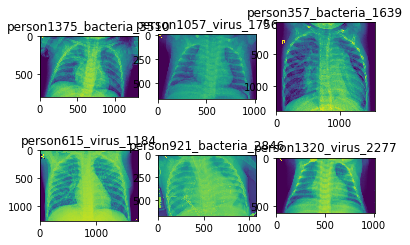

In [34]:
plot_images(type = "pneumonia", num=6)

In [36]:
pre_model = InceptionV3(weights="imagenet")









96116736/96112376 [==============================] - 6s 0us/step


In [37]:
img = image.load_img( "/content/chest_xray/test/PNEUMONIA/person100_bacteria_475.jpeg", 
                     target_size=(299, 299))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

y = pre_model.predict(x)
for index, res in enumerate(decode_predictions(y)[0]):
    print('{}. {}: {:.3f}%'.format(index + 1, res[1], 100 * res[2]))

40960/35363 [==================================] - 0s 0us/step
1. water_bottle: 73.426%
2. isopod: 16.616%
3. scorpion: 1.624%
4. trilobite: 0.468%
5. water_jug: 0.425%


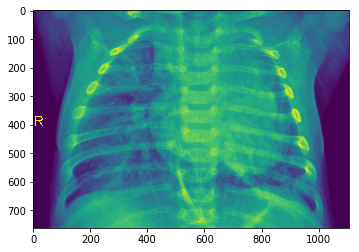

In [39]:
img = mpimg.imread("/content/chest_xray/test/PNEUMONIA/person100_bacteria_475.jpeg")
imgplot = plt.imshow(img)

In [0]:
batch_size=163


#Create training data generator
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        width_shift_range=0.1,
        height_shift_range=0.1) #Create image generator in the abstract

In [42]:
train_generator = train_datagen.flow_from_directory(
        train_dir, #directory that contains training data
        target_size=(150, 150), #what size image we want
        batch_size=batch_size, #how many files to read in at a time
        class_mode="categorical")

Found 5216 images belonging to 2 classes.


In [43]:
#Create validation data generator

val_datagen = ImageDataGenerator(rescale=1./255)

val_generator = val_datagen.flow_from_directory(
        val_dir,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode="categorical")

Found 16 images belonging to 2 classes.


In [44]:
#Create validation test generator

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(150, 150),
        batch_size=1,
        class_mode="categorical",
        shuffle=False)

Found 5216 images belonging to 2 classes.


In [46]:
base_model = InceptionV3(weights='imagenet', include_top=False)

x = base_model.output
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dense(1024, activation='relu')(x)
x = keras.layers.BatchNormalization()(x)
predictions = keras.layers.Dense(2, activation='softmax')(x)


for layer in base_model.layers:
  layer.trainable = False  # Freeze the layers not to train
  
final_model = keras.models.Model(inputs=base_model.inputs, outputs=predictions) #create final model

87916544/87910968 [==============================] - 3s 0us/step


In [47]:
final_model.compile(loss ="categorical_crossentropy", #another term for log loss
                    optimizer = "adam", 
                    metrics=["accuracy"])

In [49]:
fit_history = final_model.fit_generator(
        train_generator, #train data generator 
        steps_per_epoch=len(train_generator),
        epochs=5,
        validation_data=val_generator, #validation data generator 
        validation_steps=len(val_generator))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/5
32/32 [==============================] - 90s 3s/step - loss: 0.6486 - acc: 0.8282 - val_loss: 1.9667 - val_acc: 0.5625
Epoch 2/5
32/32 [==============================] - 81s 3s/step - loss: 0.2500 - acc: 0.9055 - val_loss: 1.2695 - val_acc: 0.6875
Epoch 3/5
32/32 [==============================] - 82s 3s/step - loss: 0.2245 - acc: 0.9155 - val_loss: 1.4012 - val_acc: 0.8125
Epoch 4/5
32/32 [==============================] - 82s 3s/step - loss: 0.2227 - acc: 0.9107 - val_loss: 1.5212 - val_acc: 0.6250
Epoch 5/5
32/32 [==============================] - 83s 3s/step - loss: 0.2197 - acc: 0.9135 - val_loss: 2.6996 - val_acc: 0.5625


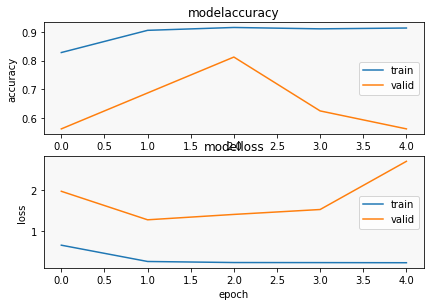

In [54]:

display_training_curves(fit_history.history['acc'], fit_history.history['val_acc'], 'accuracy', 211)
display_training_curves(fit_history.history['loss'], fit_history.history['val_loss'], 'loss', 212)

In [55]:
result  = final_model.evaluate_generator(test_generator,steps=len(test_generator))
print('Loss:', result[0])
print('Accuracy:', result[1])

Loss: 0.45027369587237737
Accuracy: 0.8784509202453987


In [56]:
train_generator.class_indices

{'NORMAL': 0, 'PNEUMONIA': 1}

In [57]:
#Generate all predictions
filenames = test_generator.filenames
nb_samples = len(filenames)
predict = final_model.predict_generator(test_generator,steps = nb_samples).argmax(axis=-1)

predict

array([1, 1, 0, ..., 1, 1, 1])

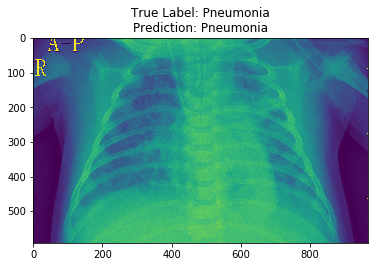

In [58]:
#@title Enter Filepath Here:
filename = "/content/chest_xray/val/PNEUMONIA/person1946_bacteria_4874.jpeg" #@param {type:"string"}

img = image.load_img(filename, 
                     target_size=(150, 150))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

y = final_model.predict(x)

predicton="Normal" if y.argmax(axis=-1)==0 else "Pneumonia"
actual="Normal" if "NORMAL" in filename else "Pneumonia" 

img=mpimg.imread(filename)
title_text = ("%s%s%s%s%s"%("True Label: ", actual, "\n", "Prediction: ", predicton))
plt.title(title_text)
imgplot=plt.imshow(img)